In [72]:
import os
import sys
import math
import glob
import itertools

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List, Optional, Union
import seaborn as sns

try:
    from nemo.utils import logging
except:
    import logging
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

## Setup/Config

In [199]:
base_metric_path = '../../data/benchmark_output'
base_nemo110_path = os.path.join(base_metric_path, 'benchmark_data_rajesh')

####
# metric_paths = [os.path.join(base_metric_path, 'CDDD'),
#                 os.path.join(base_metric_path, 'MegaMolBART/small_NeMo1.2_data_parallel'),
#                 os.path.join(base_nemo110_path, 'nemo_random'),
#                 os.path.join(base_nemo110_path, 'nemo_ea2'),
#                 os.path.join(base_nemo110_path, 'nemo_20220713'),
#                 os.path.join(base_nemo110_path, 'nemo_20220714'),
#                 os.path.join(base_nemo110_path, 'nemo_20220720')]

# metric_labels = ['CDDD', 'NeMo1.2', 'NeMo1.10_Random', 'NeMo1.10_EA2', 'NeMo1.10_20220713', 'NeMo1.10_20220714', 'NeMo1.10_20220720']

metric_paths = [os.path.join(base_metric_path, 'CDDD'),
                os.path.join(base_nemo110_path, 'nemo_20220714'),
                os.path.join(base_nemo110_path, 'nemo_20220720')]

metric_labels = ['CDDD', 'MegaMolBARTv0.2 (2022/07/14)', 'MegaMolBARTv0.2 (2022/07/20)']


acceptance_criteria = {'validity': 0.98, 'novelty': 0.50}

reports_dir = '/data/benchmark_output/reports'
save_plots = True


if save_plots:
    os.makedirs(reports_dir, exist_ok=True)

## Load Data

In [200]:
def load_files(metric_paths: List[str], 
               metric_labels: Optional[List[str]] = None, 
               parse_timestamps: bool = False,
               file_type: str = 'csv'):
    """Load aggregated metric results from CSV files"""
    
    metric_labels = metric_labels if metric_labels else [None] * len(metric_paths)
    assert len(metric_labels) == len(metric_paths)
    custom_date_parser = lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S")
    
    file_type = file_type.lower()
    assert file_type in ['csv', 'pkl'], AssertionError(f'File type must be one of "csv" or "pkl", got {file_type}.')

    combined_metric_df = []
    for metric_path, metric_label in zip(metric_paths, metric_labels):
        file_list = glob.glob(os.path.join(metric_path, '**', f'*.{file_type}'), recursive=True)
            
        metric_df = []
        for file in file_list:
            if file_type == 'csv':
                kwargs = {'parse_dates':['timestamp'], 'date_parser':custom_date_parser} if parse_timestamps else {}
                df = pd.read_csv(file, **kwargs)
            else:
                df = pd.read_pickle(file)
            
            exp_name = file.split('-')[-2] if not metric_label else metric_label
            df['exp_name'] = exp_name
            metric_df.append(df)

        metric_df = pd.concat(metric_df, axis=0).reset_index(drop=True)

        if parse_timestamps:
            metric_df['timestamp'] = metric_df['timestamp'].min()
            metric_df['timestamp'] = metric_df['timestamp'].dt.to_period('M') # Floor by month
        
        # Cleanup names -- need to regularize with team
        metric_df['name'] = metric_df['name'].str.replace('modelability-', '')

        combined_metric_df.append(metric_df)
        
    return pd.concat(combined_metric_df, axis=0).reset_index(drop=True)

## Utilities

In [201]:
def set_plotting_style(show_grid: bool = False):
    sns.set_palette('dark')
    pal = sns.color_palette()
    sns.set_palette([pal[0]] + pal[2:])
    
    if show_grid:
        kwargs = {'axes.edgecolor': 'black', 'axes.linewidth': 1.5}
    else:
        kwargs = {'axes.grid' : False}
    sns.set_style("whitegrid", kwargs)
    
    
def _label_bars(ax: plt.Axes, max_value: Optional[float] = None):
    """Add value labels to all bars in a bar plot"""
    for p in ax.patches:
        value = p.get_height()

        if value < 0:
            va = 'top'
        else:
            va = 'bottom'

        if not math.isclose(value, 0.0):
            label = "{:.2f}".format(value)
            x, y = p.get_x() * 1.005, value * 1.005

            bbox = None
            if max_value:
                if y >= max_value:
                    bbox = dict(boxstyle="square", fc=(1.0, 1.0, 1.0), ec=(0.0, 0.0, 0.0))
                y = min(y, max_value)                
            ax.annotate(label, (x, y), va=va, bbox=bbox)
            
def setup_plots(num_plots: int, 
                plots_per_row: int, 
                xscale: int = 7, 
                yscale: int = 4):
    """Setup plotting axes"""

    rows = int(math.ceil(num_plots / plots_per_row))

    fig = plt.figure(figsize=(plots_per_row * xscale, (rows * yscale)), facecolor=(1.0, 1.0, 1.0))
    axes_list = fig.subplots(rows, plots_per_row)
    if num_plots > 1:
        axes_list = axes_list.flatten()
    else:
        axes_list = [axes_list]

    for ax in axes_list[num_plots:]:
        fig.delaxes(ax)

    return fig, axes_list

## Sampling Metrics

[NeMo W 2022-08-01 19:24:12 nemo_logging:349] /tmp/ipykernel_185909/343757080.py:29: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead
    
    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      plt_df.loc[:, comparison_field] = plt_df[comparison_field].astype(exp_sort_order)
    


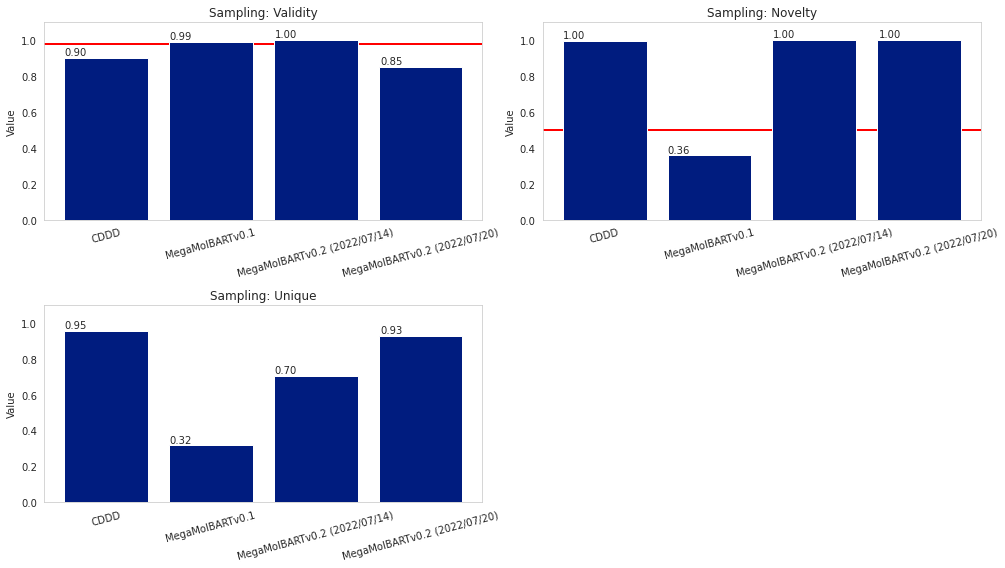

In [103]:
def make_multimodel_sampling_plots(df: pd.DataFrame, 
                                   acceptance_criteria: Optional[dict] = None,
                                   save_plots: bool = False, 
                                   plots_per_row: int = 2,
                                   reports_dir: Optional[str] = None):
    
    # Other config -- TODO consider making configurable
    kpis = ['validity', 'novelty', 'unique']
    kpi_field = 'name'
    comparison_field = 'exp_name'
    value_field = 'value'
    
    # Get selected data and preserve sort order
    exp_sort_order = pd.CategoricalDtype(df[comparison_field].unique(), ordered=True)
    query = f'{kpi_field} in {kpis}'
    df = df.query(query)[[kpi_field, comparison_field, value_field]]
    df.loc[:, comparison_field] = df[comparison_field].astype(exp_sort_order)

    # Setup plots        
    set_plotting_style()
    num_plots = len(kpis)
    fig, axes_list = setup_plots(num_plots, plots_per_row)
    

    for i, kpi in enumerate(kpis):
        query_str = f'{kpi_field} == "{kpi}"'
        plt_df = df.query(query_str)
        
        plt_df.loc[:, comparison_field] = plt_df[comparison_field].astype(exp_sort_order)
        
        labels = plt_df[comparison_field]
        values = plt_df[value_field]
        
        ax = axes_list[i]
        
        if acceptance_criteria and acceptance_criteria.get(kpi, False):
            ax.axhline(y=acceptance_criteria[kpi], xmin=0, xmax=1, color='red', lw=2.0, zorder=-1)
            
        ax.bar(labels, values)
        ax.tick_params(axis='x', rotation=15)
        ax.set_ylim(0, 1.1)
        ax.set_title(f'Sampling: {kpi.title()}')
        ax.set_ylabel('Value')
        _label_bars(ax)
        
    fig.subplots_adjust(left=0.01,
                        bottom=0.01, 
                        right=0.99, 
                        top=0.90, 
                        wspace=0.1, 
                        hspace=0.2)
    if save_plots:
        plt.tight_layout()
        save_path = os.path.join(reports_dir, 'Sampling_Aggregated_Benchmark.png')
        fig.savefig(save_path, dpi=300)


        
df = load_files(metric_paths=metric_paths, metric_labels=metric_labels, parse_timestamps=False)

sample_df_v01 = pd.DataFrame([{'name': 'validity', 'exp_name': 'MegaMolBARTv0.1', 'radius': 0.01,  'value': 0.99289},
                              {'name': 'validity', 'exp_name': 'MegaMolBARTv0.1', 'radius': 0.1,   'value': 0.98902},
                              {'name': 'novelty',  'exp_name': 'MegaMolBARTv0.1', 'radius': 0.01,  'value': 0.37505},
                              {'name': 'novelty',  'exp_name': 'MegaMolBARTv0.1', 'radius': 0.1,   'value': 0.36019},
                              {'name': 'novelty',  'exp_name': 'MegaMolBARTv0.1', 'radius': 0.5,   'value': 0.00276},
                              {'name': 'unique',   'exp_name': 'MegaMolBARTv0.1', 'radius': 0.01,  'value': 0.12857},
                              {'name': 'unique',   'exp_name': 'MegaMolBARTv0.1', 'radius': 0.1,   'value': 0.31911},
                              {'name': 'unique',   'exp_name': 'MegaMolBARTv0.1', 'radius': 0.5,   'value': 0.01619}])

df = pd.concat([sample_df_v01, df], axis=0).reset_index(drop=True)

metric_labels_full = metric_labels.copy()
metric_labels_full = metric_labels_full.insert(1, 'MegaMolBARTv0.1')
metric_labels_full = pd.CategoricalDtype(metric_labels_full, ordered=True)
df['exp_name'] = df['exp_name'].astype(metric_labels_full)
df.sort_values('exp_name', inplace=True)



# Need to prune extra radii from v0.1 and NeMo1.2 models for plotting
radii_query_str = '((exp_name == "NeMo1.2") & (name in ["validity", "novelty", "unique"]) & (radius == 0.75))'
radii_query_str += ' | ((exp_name == "MegaMolBARTv0.1") & (name in ["validity", "novelty", "unique"]) & (radius == 0.1))'
radii_query_str += ' | (exp_name not in ["MegaMolBARTv0.1", "NeMo1.2"])'
df = df.query(radii_query_str)


make_multimodel_sampling_plots(df=df, acceptance_criteria=acceptance_criteria, save_plots=save_plots, reports_dir=reports_dir)

## Similarity Search

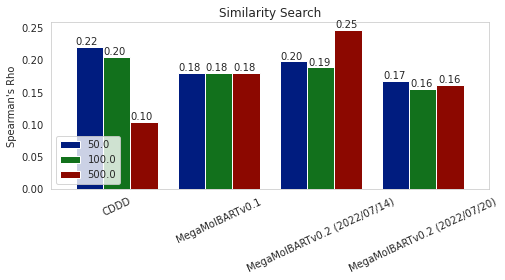

In [203]:
def make_multimodel_similarity_search_plot(df: pd.DataFrame, 
                                           save_plots: bool = False, 
                                           reports_dir: Optional[str] = None):
    
    # Other config -- TODO consider making configurable
    kpis = ['nearest neighbor correlation', 'nearest_neighbor_correlation']
    kpi_field = 'name'
    comparison_field = 'exp_name'
    value_field = 'value'
    top_k_field = 'top_k'
    
    # Get selected data and set sort order
    exp_sort_order = pd.CategoricalDtype(df[comparison_field].unique(), ordered=True)
    query = f'({kpi_field} in {kpis})'
    df = df.query(query)[[kpi_field, comparison_field, value_field, top_k_field]]
    df.loc[:, comparison_field] = df[comparison_field].astype(exp_sort_order)

    # Setup plots
    set_plotting_style()
    num_plots = 1
    plots_per_row = 1
    fig, axes_list = setup_plots(num_plots, plots_per_row)
    ax = axes_list[0]
    
    contains_duplicates = df.groupby([top_k_field, comparison_field]).size().max() > 1
    if contains_duplicates:
        logging.info(f'Dataframe contains duplicate values. They will be averaged.')

    plot_df = df.pivot_table(columns=[top_k_field], values=value_field, index=comparison_field, aggfunc='mean')
    plot_df.plot(kind='bar', width=0.8, ax=ax).legend(loc=3)
    _label_bars(ax)

    #ax.set_ylim(ymin, ymax)
    ax.tick_params(axis='x', rotation=25)
    ax.set_title(f'Similarity Search')
    ax.set_xlabel('')
    ax.set_ylabel(f"Spearman's Rho")

    fig.subplots_adjust(left=0.01,
               bottom=0.01, 
               right=0.99, 
               top=0.90, 
               wspace=0.1, 
               hspace=0.2)
    
    if save_plots:
        plt.tight_layout()
        save_path = os.path.join(reports_dir, 'Similarity_Search_Aggregated_Benchmark.png')
        fig.savefig(save_path, dpi=300)
        
    return


df = load_files(metric_paths=metric_paths, metric_labels=metric_labels, parse_timestamps=False)


# nearest neighbor
sample_df_v01 = pd.DataFrame([{'name': 'nearest neighbor correlation', 'exp_name': 'MegaMolBARTv0.1', 'top_k': 50.0,  'value': 0.17891251564751073},
                      {'name': 'nearest neighbor correlation', 'exp_name': 'MegaMolBARTv0.1', 'top_k': 100.0, 'value': 0.17891251564751073},
                      {'name': 'nearest neighbor correlation', 'exp_name': 'MegaMolBARTv0.1', 'top_k': 500.0, 'value': 0.17891251564751073}])

df = pd.concat([sample_df_v01, df], axis=0).reset_index(drop=True)

metric_labels_full = metric_labels.copy()
metric_labels_full = metric_labels_full.insert(1, 'MegaMolBARTv0.1')
metric_labels_full = pd.CategoricalDtype(metric_labels_full, ordered=True)
df['exp_name'] = df['exp_name'].astype(metric_labels_full)
df.sort_values('exp_name', inplace=True)

# radii_query_str = 'top_k == 100.0'
# df = df.query(radii_query_str)
########

make_multimodel_similarity_search_plot(df=df, save_plots=save_plots, reports_dir=reports_dir)

## Embedding Physchem

[NeMo I 2022-08-01 20:29:13 3925398503:32] exp_name                      model                 
    CDDD                          linear_regression         19.504954
                                  random_forest              2.237152
                                  support_vector_machine     3.875812
    MegaMolBARTv0.2 (2022/07/14)  linear_regression          1.445670
                                  random_forest              1.274344
                                  support_vector_machine     2.349112
    MegaMolBARTv0.2 (2022/07/20)  linear_regression          1.302578
                                  random_forest              1.635291
                                  support_vector_machine     2.664364
    Name: value, dtype: float64
[NeMo I 2022-08-01 20:29:13 3925398503:44] Dataframe for logD contains duplicate values. They will be averaged.


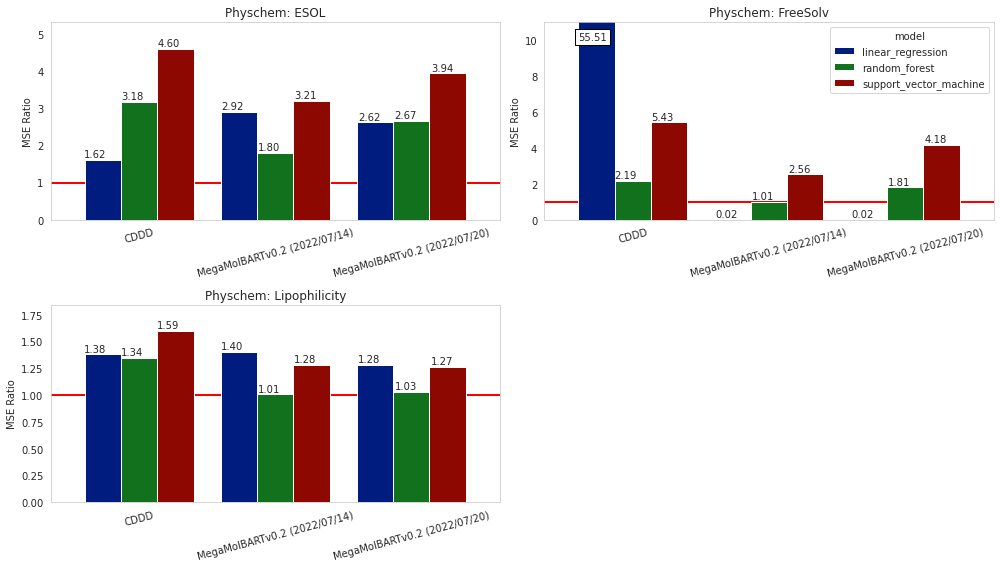

In [147]:
def _extract_physchem_name(dataset_names: List[str]):
    dataset_converter = {'esol':'ESOL', 'freesolv':'FreeSolv', 'lipophilicity':'Lipophilicity'}
    
    name = None
    for name in dataset_names:
        if '_' in name:
            key = name.split('_')[-1]
            name = dataset_converter.get(key, None)
    return name

def make_multimodel_physchem_plots(df: pd.DataFrame, 
                                   save_plots: bool = False, 
                                   max_plot_ratio: float = 10.0,
                                   plots_per_row: int = 2,
                                   reports_dir: Optional[str] = None):
    
    # Other config -- TODO consider making configurable
    kpis = ['physchem', 'physchem_esol', 'physchem_freesolv', 'physchem_lipophilicity']
    models = ['linear_regression', 'support_vector_machine', 'random_forest']
    kpi_field = 'name'
    model_field = 'model'
    comparison_field = 'exp_name'
    value_field = 'value'
    property_field = 'property'
    
    # Get selected data and set sort order
    exp_sort_order = pd.CategoricalDtype(df[comparison_field].unique(), ordered=True)
    query = f'({kpi_field} in {kpis}) & ({model_field} in {models})'
    df = df.query(query)[[kpi_field, comparison_field, value_field, property_field, model_field]]
    df.loc[:, comparison_field] = df[comparison_field].astype(exp_sort_order)
    
    logging.info(f'{df.groupby([comparison_field, model_field])[value_field].mean()}')

    # Setup plots
    set_plotting_style()
    num_plots = len(df[property_field].unique())
    fig, axes_list = setup_plots(num_plots, plots_per_row)
    
    for i, (property_, plot_df) in enumerate(df.groupby(property_field, sort=False)):        
        ax = axes_list[i]
        
        contains_duplicates = plot_df.groupby([model_field, comparison_field]).size().max() > 1
        if contains_duplicates:
            logging.info(f'Dataframe for {property_} contains duplicate values. They will be averaged.')
        
        dataset_name = plot_df['name'].unique()
        dataset_name = _extract_physchem_name(dataset_name)
        
        plot_df = plot_df.pivot_table(columns=[model_field], values=value_field, index=comparison_field, aggfunc='mean')
        legend = True if i == 1 else False
        plot_df.plot(kind='bar', width=0.8, ax=ax, legend=legend)
        
        ax.axhline(1.0, 0, 1, color='red', lw=2.0, zorder=-1)
        
        
        ymin, ymax = ax.get_ylim()
        ymax = min(ymax, max_plot_ratio) * 1.1
        _label_bars(ax, 0.9 * ymax)
        
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='x', rotation=15)
        
        if dataset_name:
            title_str = f'Physchem: {dataset_name}'
        else:
            units = property_.replace('_', ' ')
            title_str = f'Physchem: {units}'
        
        ax.set_title(title_str)
        ax.set_xlabel('')
        ax.set_ylabel(f'MSE Ratio')
        
        fig.subplots_adjust(left=0.01,
                    bottom=0.01, 
                    right=0.99, 
                    top=0.90, 
                    wspace=0.1, 
                    hspace=0.2)
    if save_plots:
        plt.tight_layout()
        save_path = os.path.join(reports_dir, 'Physchem_Aggregated_Benchmark.png')
        fig.savefig(save_path, dpi=300)
        
    return

df = load_files(metric_paths=metric_paths, metric_labels=metric_labels, parse_timestamps=False)
make_multimodel_physchem_plots(df=df, save_plots=save_plots, reports_dir=reports_dir)

## Embedding Bioactivity

[NeMo I 2022-08-01 19:05:29 1650487965:25] The genes being plotted have been limited to ['ABL1', 'ACHE', 'ADAM17', 'ADORA2A', 'ADORA2B', 'ADORA3', 'ADRA1A', 'ADRA1D', 'ADRB1', 'ADRB2', 'ADRB3', 'AKT1', 'AKT2', 'ALK', 'ALOX5', 'AR', 'AURKA', 'AURKB', 'BACE1', 'CA1', 'CA12', 'CA2', 'CA9', 'CASP1', 'CCKBR', 'CCR2', 'CCR5', 'CDK1', 'CDK2']
[NeMo I 2022-08-01 19:05:29 1650487965:45] linear_regression
[NeMo I 2022-08-01 19:05:29 1650487965:46] exp_name
    CDDD                            0.875227
    MegaMolBARTv0.2 (2022/07/14)    0.814239
    MegaMolBARTv0.2 (2022/07/20)    0.873013
    Name: value, dtype: float64
[NeMo I 2022-08-01 19:05:29 1650487965:45] support_vector_machine
[NeMo I 2022-08-01 19:05:29 1650487965:46] exp_name
    CDDD                            0.878947
    MegaMolBARTv0.2 (2022/07/14)    0.811882
    MegaMolBARTv0.2 (2022/07/20)    0.841395
    Name: value, dtype: float64
[NeMo I 2022-08-01 19:05:29 1650487965:45] random_forest
[NeMo I 2022-08-01 19:05:29 1650487965:4

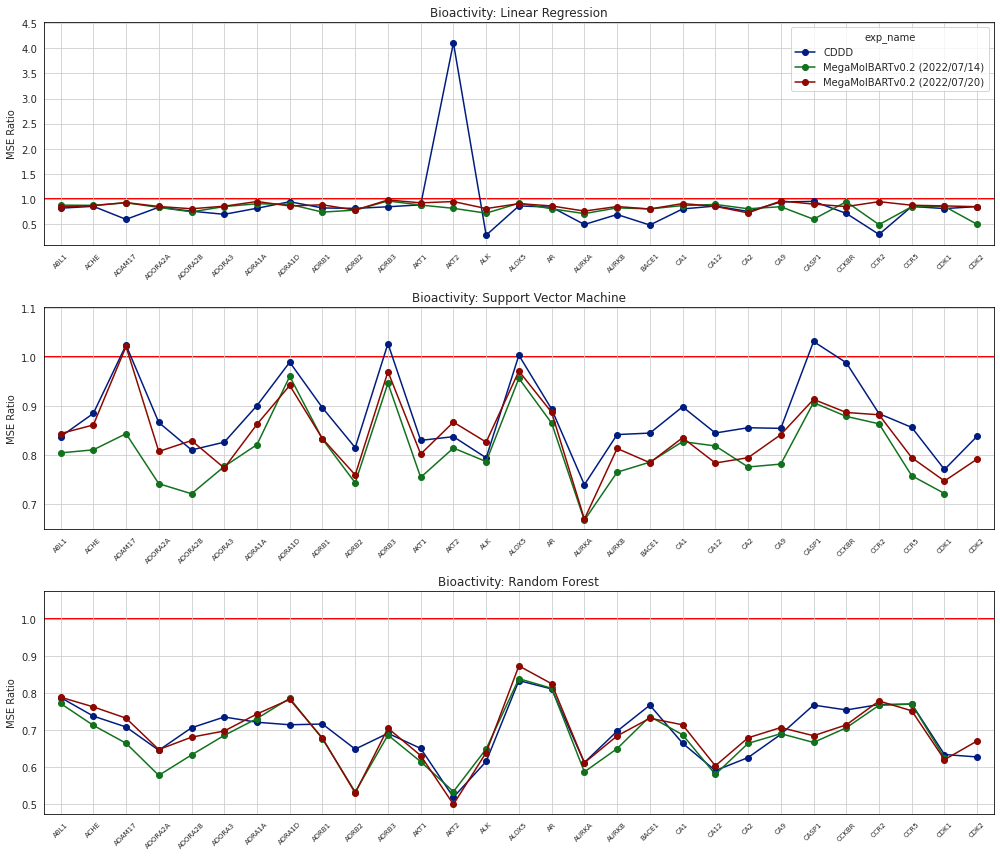

In [98]:
def make_multimodel_bioactivity_plots(df: pd.DataFrame, 
                                       save_plots: bool = False, 
                                       max_plot_ratio: float = 5.0,
                                       plot_type: str = 'line',
                                       plots_per_row: int = 1,
                                       limit_genes: Optional[Union[str, int]] = None,
                                       reports_dir: Optional[str] = None):
    
    # Other config -- TODO consider making configurable
    kpis = ['bioactivity']
    models = ['linear_regression', 'support_vector_machine', 'random_forest']
    kpi_field = 'name'
    model_field = 'model'
    comparison_field = 'exp_name'
    value_field = 'value'
    property_field = 'gene'
    
    # Get selected data and set sort order
    exp_sort_order = pd.CategoricalDtype(df[comparison_field].unique(), ordered=True)
    query = f'({kpi_field} in {kpis}) & ({model_field} in {models})'
    
    gene_list = sorted(df[property_field].dropna().unique())
    if limit_genes:
        limit_index = gene_list.index(limit_genes) if isinstance(limit_genes, str) else limit_genes
        gene_list = gene_list[: limit_index+1]
        logging.info(f'The genes being plotted have been limited to {gene_list}')
        query += f' & ({property_field} in {gene_list})'
    
    df = df.query(query)[[kpi_field, comparison_field, value_field, property_field, model_field]]
    df.loc[:, comparison_field] = df[comparison_field].astype(exp_sort_order)
    n_genes = len(gene_list)
    
    # Setup plots
    set_plotting_style(show_grid=True)
    num_plots = len(models)
    
    fig, axes_list = setup_plots(num_plots, plots_per_row, xscale=14)
    
    for i, (model_, plot_df) in enumerate(df.groupby(model_field, sort=False)):
        ax = axes_list[i]
        
        contains_duplicates = plot_df.groupby([comparison_field, property_field]).size().max() > 1
        if contains_duplicates:
            logging.info(f'Dataframe for {model_} contains duplicate values. They will be averaged.')
        
        logging.info(f'{model_}')
        logging.info(f'{plot_df.groupby([comparison_field])[value_field].mean()}')
        plot_df = plot_df.pivot_table(columns=[comparison_field], values=value_field, index=property_field, aggfunc='mean')
        legend = True if i == 0 else False
        kwargs = {'kind':'line', 'marker':'o'} if plot_type == 'line' else {'kind':'bar', width:0.8}
        plot_df.plot(ax=ax, legend=legend, **kwargs)
        
        ax.axhline(1.0, 0, 1, color='red', lw=2.0, zorder=-1)
        
        ymin, ymax = ax.get_ylim()
        ymax = min(ymax, max_plot_ratio) * 1.05
        _label_bars(ax, 0.9 * ymax)
        
        ax.set_ylim(ymin, ymax)
        ax.set_ylabel(f'MSE Ratio')
        
        ax.set_xlim(-0.5, n_genes - 0.5)
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.set_xticks(range(0, n_genes))
        ax.set_xticklabels(gene_list, rotation=45, size='7')
        ax.set_xlabel('')
        
        model_title = model_.replace('_', ' ').title()
        ax.set_title(f'Bioactivity: {model_title}')
        
        fig.subplots_adjust(left=0.01,
                    bottom=0.01, 
                    right=0.99, 
                    top=0.90, 
                    wspace=0.1, 
                    hspace=0.2)
    if save_plots:
        plt.tight_layout()
        save_path = os.path.join(reports_dir, 'Bioactivity_Aggregated_Benchmark.png')
        fig.savefig(save_path, dpi=300)
            
    return plot_df
            

df = load_files(metric_paths=metric_paths, metric_labels=metric_labels, parse_timestamps=False)
plot_df = make_multimodel_bioactivity_plots(df=df, limit_genes='CDK2', save_plots=save_plots, reports_dir=reports_dir, max_plot_ratio=5.0)

## Embedding Diagnostic Plots

In [348]:
from cuchembench.datasets.physchem import (MoleculeNetESOL,
                                        MoleculeNetFreeSolv,
                                        MoleculeNetLipophilicity)

from cuchembench.datasets.bioactivity import ExCAPEDataset

def load_physchem_input_data(max_seq_len):
    """Create dataframe wtih input physchem property values that are predicted from models"""
    dataset_list = [MoleculeNetESOL(max_seq_len=max_seq_len),
                           MoleculeNetFreeSolv(max_seq_len=max_seq_len),
                           MoleculeNetLipophilicity(max_seq_len=max_seq_len)]

    input_data = {}
    for dataset in dataset_list:
        dataset.load(columns=['SMILES'])
        property_name = dataset.properties_cols[0]
        data = dataset.properties
        data = data.rename(columns={property_name: 'value'})
        input_data[property_name] = data.values.squeeze()

    return input_data


def load_bioactivity_input_data(max_seq_len):
    """Create dataframe wtih input bioactivity values that are predicted from models"""
    dataset = ExCAPEDataset(max_seq_len=max_seq_len)

    dataset.load(columns=['SMILES', 'Gene_Symbol'])
    property_name = dataset.properties_cols[0]

    input_data = dataset.properties.copy()
    input_data.index = dataset.smiles.index
    input_data.rename(columns={property_name: 'value'}, inplace=True)
    input_data = input_data.reset_index(level='gene')
    input_data = dict(tuple(input_data.groupby('gene')['value']))
    input_data = {k: v.values.squeeze() for k, v in input_data.items()}
    return input_data

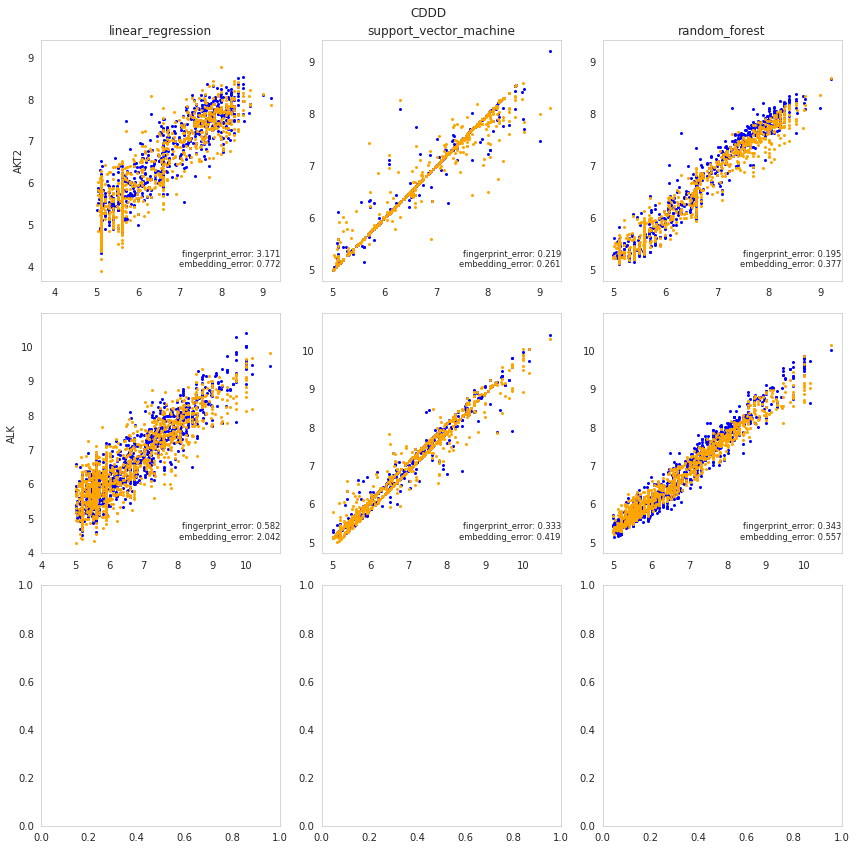

In [352]:
from matplotlib.backends.backend_pdf import PdfPages

####

def make_model_plots(metric_paths: List[str], 
                     metric_labels: List[str],
                     exp_name: str,
                     max_seq_len: int, 
                     plot_type: str, 
                     reports_dir: str, 
                     num_rows_per_page: int = 3,
                     property_list: Optional[List[str]] = None):

    assert plot_type in ['physchem', 'bioactivity'], AssertionError(f'Error: plot_type must be one of "physchem", "bioactivity", got {plot_type}.')
    # Add assertion for single exp_name
                                
    
    kpi_field = 'name'
    model_field = 'model'
    comparison_field = 'exp_name'
    models = ['linear_regression', 'support_vector_machine', 'random_forest']

    if plot_type == 'physchem':
        kpis = ['physchem', 'physchem_esol', 'physchem_freesolv', 'physchem_lipophilicity']
        properties_field = 'property'
        input_data = load_physchem_input_data(max_seq_len=max_seq_len)
        save_path = os.path.join(reports_dir, f'Physchem_Model_Diagnostic_Plots_{exp_name}.pdf')
    else:
        kpis = ['bioactivity']
        properties_field = 'gene'
        input_data = load_bioactivity_input_data(max_seq_len=max_seq_len)
        save_path = os.path.join(reports_dir, f'Bioactivity_Model_Diagnostic_Plots_{exp_name}.pdf')

    df = load_files(metric_paths=metric_paths, metric_labels=metric_labels, file_type='pkl')

    # Get selected data
    query = f'({kpi_field} in {kpis}) & ({comparison_field} == "{exp_name}")'
    if property_list:
        query += f' & ({properties_field} in {property_list})'
    df = df.query(query)
    properties = df[properties_field].unique()

    plots_per_row = len(models)
    num_rows = len(properties)
    num_plots = plots_per_row * num_rows_per_page
    num_pages = int(math.ceil(num_rows / num_rows_per_page))

    with PdfPages(save_path) as pdf:
        for page in range(num_pages):
            fig, ax_list = setup_plots(num_plots=num_plots, plots_per_row=plots_per_row, xscale=4, yscale=4)
            for row, property_ in enumerate(properties):
                for col, model in enumerate(models):
                    xdata = input_data[property_]
                    mask = (df[model_field] == model) & (df[properties_field] == property_)        

                    predictions = df[mask]['predictions'].values[0]
                    fingerprint_pred = predictions['fingerprint_pred']
                    embedding_pred = predictions['embedding_pred']

                    pos = (row * plots_per_row) + col
                    ax = ax_list[pos]
                    ax.plot(xdata, fingerprint_pred, marker='o', ls='', ms=2, color='blue', label='Fingerprint')
                    ax.plot(xdata, embedding_pred, marker='o', ls='', ms=2, color='orange', label='Embedding')

                    if row == 0:
                        ax.set_title(model)
                    if col == 0:
                        ax.set_ylabel(property_)

                    xlim = ax.get_xlim()
                    ylim = ax.get_ylim()
                    lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
                    ax.set_xlim(*lim)
                    ax.set_ylim(*lim)

                    # Label with error values
                    fingerprint_error = df[mask]['fingerprint_error'].values[0]
                    embedding_error = df[mask]['embedding_error'].values[0]
                    error_str = [f'fingerprint_error: {fingerprint_error:.3f}',
                                 f'embedding_error: {embedding_error:.3f}']
                    error_str = '\n'.join(error_str)
                    ax.annotate(error_str, xy=(1.0, 0.05), xycoords='axes fraction', fontsize='small', ha='right', va='bottom')

            fig.suptitle(exp_name)
            plt.tight_layout()
            pdf.savefig(fig)


######
metric_paths = [os.path.join(base_metric_path, 'CDDD'),
                os.path.join(base_metric_path, 'MegaMolBART/small_NeMo1.2_data_parallel'),
                os.path.join(base_nemo110_path, 'nemo_random'),
                os.path.join(base_nemo110_path, 'nemo_ea2'),
                os.path.join(base_nemo110_path, 'nemo_20220713'),
                os.path.join(base_nemo110_path, 'nemo_20220714'),
                os.path.join(base_nemo110_path, 'nemo_20220720')]

metric_labels = ['CDDD', 'NeMo1.2', 'NeMo1.10_Random', 'NeMo1.10_EA2', 'NeMo1.10_20220713', 'NeMo1.10_20220714', 'NeMo1.10_20220720']
######

exp_name = 'CDDD' # 'CDDD' 'NeMo1.2' 'NeMo1.10_20220714' 'NeMo1.10_20220720'
max_seq_len = 512
num_rows_per_page = 3
# metric_paths, metric_labels


make_model_plots(metric_paths=metric_paths, metric_labels=metric_labels, exp_name=exp_name,
                 max_seq_len=max_seq_len, plot_type='bioactivity', reports_dir=reports_dir, 
                 num_rows_per_page=num_rows_per_page, property_list=['AKT2', 'ALK'])



In [188]:
max_seq_len = 512
df = load_files(metric_paths=metric_paths, metric_labels=metric_labels, file_type='pkl')
input_data = load_physchem_input_data(max_seq_len=max_seq_len)


#### Refector to function to load 

kpis = ['physchem', 'physchem_esol', 'physchem_freesolv', 'physchem_lipophilicity']  ## WILL CHANGE
property_field = 'property' ## WILL CHANGE

models = ['linear_regression', 'support_vector_machine', 'random_forest']
kpi_field = 'name'
model_field = 'model'
comparison_field = 'exp_name'
value_field = 'value'
prediction_field = 'predictions'


# Get selected data
query = f'({kpi_field} in {kpis}) & ({model_field} in {models})'
df = df.query(query)[[kpi_field, comparison_field, value_field, property_field, model_field, prediction_field]]

plot_data = []
for _, row in df.iterrows():
    df_ = pd.DataFrame(row['predictions']).rename(columns=lambda x: x.replace('_pred', ''))
    
    property_name = row[property_field]
    df_[value_field] = input_data[property_name]
    df_[property_field] = row[property_field]
    
    df_[kpi_field] = row[kpi_field]
    df_[comparison_field] = row[comparison_field]
    df_[model_field] = row[model_field]

    plot_data.append(df_)
    
plot_data = pd.concat(plot_data, axis=0)
    

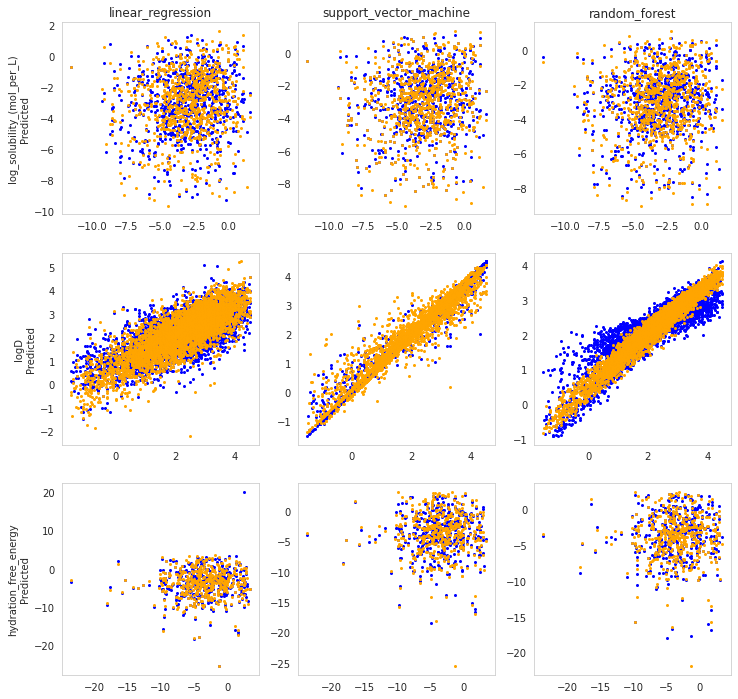

In [198]:
# df = plot_data.query('exp_name == "MegaMolBARTv0.2 (2022/07/20)"')
df = plot_data.query('exp_name == "MegaMolBARTv0.2 (2022/07/14)"')
# df = plot_data.query('exp_name == "CDDD"')

property_field = 'property' ## WILL CHANGE
model_field = 'model'
models = ['linear_regression', 'support_vector_machine', 'random_forest']
comparison_field = 'exp_name'
fingerprint_field = 'fingerprint'
embedding_field = 'embedding'
value_field = 'value'

# Setup plots
set_plotting_style()
plots_per_row = len(models)
num_plots = df[property_field].nunique() * plots_per_row

num_pages = df[comparison_field].nunique()
fig, axes_list = setup_plots(num_plots, plots_per_row, xscale=4, yscale=4)

for row, property_ in enumerate(df[property_field].unique()):
    for col, model in enumerate(models):
        query_str = f'({property_field} == "{property_}") & ({model_field} == "{model}")'
        plot_data_ = df.query(query_str)
        
        pos = (row * plots_per_row) + col
        ax = axes_list[pos]
        ax.plot(plot_data_[value_field], plot_data_[fingerprint_field], ms=2, marker='o', ls='', color='blue', label='fingerprint')
        ax.plot(plot_data_[value_field], plot_data_[embedding_field], ms=2, marker='o', ls='', color='orange', label='fingerprint')
        if row == 0:
            ax.set_title(model)
        if col == 0:
            ax.set_ylabel(f'{property_}\nPredicted')

In [ ]:
####


# # Other config -- TODO consider making configurable
# kpis = ['physchem', 'physchem_esol', 'physchem_freesolv', 'physchem_lipophilicity']
# models = ['linear_regression', 'support_vector_machine', 'random_forest']
# kpi_field = 'name'
# model_field = 'model'
# comparison_field = 'exp_name'
# value_field = 'value'
# property_field = 'property'



# # Get selected data and set sort order
# exp_sort_order = pd.CategoricalDtype(df[comparison_field].unique(), ordered=True)
# query = f'({kpi_field} in {kpis}) & ({model_field} in {models})'
# df = df.query(query)[[kpi_field, comparison_field, value_field, property_field, model_field]]
# df.loc[:, comparison_field] = df[comparison_field].astype(exp_sort_order)